In [5]:
# ============================
# PART 1 — FAST TRAINING SETUP
# ============================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import time

# -----------------
# Device
# -----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# -----------------
# Transforms (smaller images = faster)
# -----------------
transform_train = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# -----------------
# Dataset
# -----------------
dataset_path = "/kaggle/input/plantvillage-dataset/color"

train_data = datasets.ImageFolder(dataset_path, transform=transform_train)
test_data  = datasets.ImageFolder(dataset_path, transform=transform_test)

# Optional: Use subset for fast debugging
small_train_data = Subset(train_data, np.arange(2000))  # first 2000 images
small_test_data  = Subset(test_data, np.arange(500))    # first 500 images

train_loader = DataLoader(small_train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(small_test_data, batch_size=32, shuffle=False)

num_classes = len(train_data.classes)
print("Classes:", num_classes)

# -----------------
# DenseNet Model
# -----------------
from torchvision.models import DenseNet121_Weights

class DenseNetCustom(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
        # Freeze all feature layers
        for param in self.model.features.parameters():
            param.requires_grad = False
        # Replace classifier
        self.model.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        return self.model(x)

model = DenseNetCustom(num_classes).to(device)

# -----------------
# Optimizer & Loss
# -----------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.model.classifier.parameters(), lr=1e-3)  # only classifier params

# -----------------
# Training Loop
# -----------------
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

def train_model(model, epochs=20):  # UPDATED: epochs=15
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        start_time = time.time()

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()*imgs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss/len(train_loader.dataset)
        train_acc  = 100*correct/total

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()*imgs.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

        val_loss /= len(test_loader.dataset)
        val_acc  = 100*correct/total

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Time: {time.time()-start_time:.1f} sec")
        print("-"*50)

train_model(model, epochs=20)


Using: cpu
Classes: 38
Epoch 1/20 | Train Loss: 0.8757, Train Acc: 72.45% | Val Loss: 0.2984, Val Acc: 97.40%
Time: 111.5 sec
--------------------------------------------------
Epoch 2/20 | Train Loss: 0.2860, Train Acc: 94.60% | Val Loss: 0.1641, Val Acc: 98.20%
Time: 112.3 sec
--------------------------------------------------
Epoch 3/20 | Train Loss: 0.1989, Train Acc: 95.55% | Val Loss: 0.1417, Val Acc: 98.20%
Time: 112.1 sec
--------------------------------------------------
Epoch 4/20 | Train Loss: 0.1558, Train Acc: 96.90% | Val Loss: 0.1175, Val Acc: 98.80%
Time: 111.7 sec
--------------------------------------------------
Epoch 5/20 | Train Loss: 0.1396, Train Acc: 96.95% | Val Loss: 0.1218, Val Acc: 98.20%
Time: 111.4 sec
--------------------------------------------------
Epoch 6/20 | Train Loss: 0.1168, Train Acc: 97.25% | Val Loss: 0.0936, Val Acc: 98.60%
Time: 111.5 sec
--------------------------------------------------
Epoch 7/20 | Train Loss: 0.1018, Train Acc: 97.75% | 

In [6]:
# ============================
# PART 2 — FAST CORE METRICS
# ============================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, log_loss, cohen_kappa_score, matthews_corrcoef
)
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Subset, DataLoader

# -----------------
# Create a fast balanced test set
# -----------------
per_class = 10  # number of images per class
indices = []

targets = np.array(test_data.targets)  # all labels in test_data

for cls in range(num_classes):
    cls_indices = np.where(targets == cls)[0][:per_class]  # first 10 images per class
    indices.extend(cls_indices)

balanced_test_data = Subset(test_data, indices)
test_loader = DataLoader(balanced_test_data, batch_size=32, shuffle=False)

# -----------------
# Collect predictions & probabilities
# -----------------
model.eval()
all_labels = []
all_preds  = []
all_probs  = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)
all_probs  = np.array(all_probs)

# -----------------
# Core Metrics
# -----------------
accuracy  = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall    = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1        = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
conf_mat  = confusion_matrix(all_labels, all_preds)
mcc       = matthews_corrcoef(all_labels, all_preds)
kappa     = cohen_kappa_score(all_labels, all_preds)
logloss   = log_loss(all_labels, all_probs, labels=np.arange(num_classes))

# -----------------
# Specificity (TNR) per class
# -----------------
tnr_list = []
for i in range(num_classes):
    TP = conf_mat[i,i]
    FP = conf_mat[:,i].sum() - TP
    FN = conf_mat[i,:].sum() - TP
    TN = conf_mat.sum() - (TP + FP + FN)
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0
    tnr_list.append(TNR)
specificity = np.mean(tnr_list)

# -----------------
# AUC-ROC (multi-class)
# -----------------
try:
    auc_roc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
except:
    auc_roc = None

# -----------------
# Print Results
# -----------------
print("=========== CORE METRICS ===========")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"Specificity (TNR): {specificity:.4f}")
print(f"AUC-ROC: {auc_roc}")
print(f"Log Loss: {logloss:.4f}")
print(f"Matthews Corr Coef: {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print("Confusion Matrix:\n", conf_mat)


=========== CORE METRICS ===========
Accuracy:  0.1053
Precision: 0.0140
Recall:    0.1053
F1-Score:  0.0242
Specificity (TNR): 0.9758
AUC-ROC: 0.5849431009957325
Log Loss: 11.3109
Matthews Corr Coef: 0.0958
Cohen's Kappa: 0.0811
Confusion Matrix:
 [[10  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 7  0  1 ...  0  0  0]
 [ 9  0  0 ...  0  0  0]
 [ 8  0  2 ...  0  0  0]]


In [7]:
# ============================
# PART 3 — LEARNING CURVE ANALYSIS
# ============================

import numpy as np

print("\n=========== LEARNING CURVE ANALYSIS ===========")

train_loss_curve = np.array(history["train_loss"])
val_loss_curve   = np.array(history["val_loss"])
train_acc_curve  = np.array(history["train_acc"])
val_acc_curve    = np.array(history["val_acc"])

epochs = len(train_loss_curve)

# ------------------------------------------------
# 1. Generalization Gap (average gap between train & val accuracy)
# ------------------------------------------------
generalization_gap = np.mean(train_acc_curve - val_acc_curve)
print(f"Generalization Gap: {generalization_gap:.4f}")

# ------------------------------------------------
# 2. Overfitting Point (first epoch where val_loss increases)
# ------------------------------------------------
overfit_epoch = None
for i in range(1, epochs):
    if val_loss_curve[i] > val_loss_curve[i-1]:
        overfit_epoch = i + 1
        break

print(f"Overfitting Begins At: {overfit_epoch if overfit_epoch else 'No clear overfitting'}")

# ------------------------------------------------
# 3. Convergence Speed (epoch where loss reduces to 15% of start)
# ------------------------------------------------
start_loss = train_loss_curve[0]
target_loss = start_loss * 0.15

conv_epoch = None
for i in range(epochs):
    if train_loss_curve[i] <= target_loss:
        conv_epoch = i + 1
        break

print(f"Convergence Speed (Epoch): {conv_epoch if conv_epoch else 'Did not reach target'}")

# ------------------------------------------------
# 4. Training Stability (variance of accuracy)
# ------------------------------------------------
stability = np.var(train_acc_curve)
print(f"Training Stability (Variance): {stability:.6f}")

# ------------------------------------------------
# 5. Asymptotic Performance / Plateau Detection
# (checks if improvement in last 5 epochs is small)
# ------------------------------------------------
if epochs >= 6:
    recent_improvement = train_loss_curve[-6] - train_loss_curve[-1]
    plateau = recent_improvement < 0.01
else:
    plateau = False

print(f"Asymptotic Plateau Reached: {plateau}")

# ------------------------------------------------
# 6. Sample Efficiency (accuracy per 100 samples)
# ------------------------------------------------
num_train_samples = len(train_loader.dataset)
sample_efficiency = train_acc_curve[-1] / num_train_samples * 100

print(f"Sample Efficiency: {sample_efficiency:.6f} accuracy per 100 samples")



=========== LEARNING CURVE ANALYSIS ===========
Generalization Gap: -2.2100
Overfitting Begins At: 5
Convergence Speed (Epoch): 6
Training Stability (Variance): 31.900150
Asymptotic Plateau Reached: True
Sample Efficiency: 4.937500 accuracy per 100 samples


In [8]:
# ===========================================
# PART 4 — ADVANCED METRICS + FAIRNESS BLOCK
# ===========================================

import numpy as np
from sklearn.metrics import (
    matthews_corrcoef, cohen_kappa_score,
    confusion_matrix, accuracy_score
)

print("\n========== PART 4 — ADVANCED METRICS ==========")

# --------------------------------
# Already computed in Part-2:
# all_labels, all_preds, all_probs
# --------------------------------

# ======================================================
# 1. MCC + COHEN'S KAPPA (Core metrics that were missing)
# ======================================================

mcc_score = matthews_corrcoef(all_labels, all_preds)
kappa_score = cohen_kappa_score(all_labels, all_preds)

print(f"MCC (Matthews Corr Coef): {mcc_score:.4f}")
print(f"Cohen’s Kappa: {kappa_score:.4f}")

# ======================================================
# 2. SYNTHETIC FAIRNESS METRICS
# ======================================================

print("\n========== FAIRNESS METRICS (Synthetic Example) ==========")

# ----------------------------------------------------------
# Create synthetic "groups" since PlantVillage has no metadata
# ----------------------------------------------------------
np.random.seed(42)
groups = np.random.choice(["Group A", "Group B"], size=len(all_labels))

# -------------------------------------
# Function to compute fairness measures
# -------------------------------------
def group_accuracy(labels, preds, group, group_name):
    idx = (group == group_name)
    return accuracy_score(labels[idx], preds[idx])

def tpr(labels, preds, cls):
    cm = confusion_matrix(labels, preds, labels=[cls])
    TP = cm[0,0]
    FN = cm.sum() - TP
    return TP / (TP + FN + 1e-9)

# ---------------------------------------
# 2.1 DEMOGRAPHIC PARITY (DP) DIFFERENCE
# ---------------------------------------
acc_A = group_accuracy(all_labels, all_preds, groups, "Group A")
acc_B = group_accuracy(all_labels, all_preds, groups, "Group B")
demographic_parity_diff = abs(acc_A - acc_B)

# ---------------------------------------
# 2.2 EQUAL OPPORTUNITY (TPR parity)
# ---------------------------------------
tpr_A = np.mean([
    tpr(all_labels[groups=="Group A"], all_preds[groups=="Group A"], cls)
    for cls in range(num_classes)
])

tpr_B = np.mean([
    tpr(all_labels[groups=="Group B"], all_preds[groups=="Group B"], cls)
    for cls in range(num_classes)
])

equal_opportunity_diff = abs(tpr_A - tpr_B)

# ---------------------------------------
# 2.3 EQUALIZED ODDS
# ---------------------------------------
# Here we approximate by comparing TPR
equalized_odds_diff = equal_opportunity_diff

# ---------------------------------------
# 2.4 PREDICTIVE PARITY (PPV parity)
# ---------------------------------------
def ppv(labels, preds):
    cm = confusion_matrix(labels, preds)
    TP = np.diag(cm)
    predicted_pos = cm.sum(axis=0)
    return (TP / (predicted_pos + 1e-9)).mean()

ppv_A = ppv(all_labels[groups=="Group A"], all_preds[groups=="Group A"])
ppv_B = ppv(all_labels[groups=="Group B"], all_preds[groups=="Group B"])

predictive_parity_diff = abs(ppv_A - ppv_B)

# ---------------------------------------
# 2.5 DISPARATE IMPACT RATIO
# ---------------------------------------
dir_ratio = (acc_A + 1e-9) / (acc_B + 1e-9)

# ---------------------------------------
# 2.6 COUNTERFACTUAL FAIRNESS
# ---------------------------------------
counterfactual_fairness = (
    "Not possible — needs causal model & sensitive attributes."
)

# ---------------------------------------
# 2.7 GROUP FAIRNESS (simple variance)
# ---------------------------------------
group_fairness_variance = np.var([acc_A, acc_B])

# ---------------------------------------
# PRINT FAIRNESS RESULTS
# ---------------------------------------
print(f"Demographic Parity Difference: {demographic_parity_diff:.4f}")
print(f"Equal Opportunity Difference:  {equal_opportunity_diff:.4f}")
print(f"Equalized Odds Difference:     {equalized_odds_diff:.4f}")
print(f"Predictive Parity Difference:  {predictive_parity_diff:.4f}")
print(f"Disparate Impact Ratio:        {dir_ratio:.4f}")
print(f"Group Fairness (Variance):     {group_fairness_variance:.4f}")
print(f"Counterfactual Fairness:       {counterfactual_fairness}")



========== PART 4 — ADVANCED METRICS ==========
MCC (Matthews Corr Coef): 0.0958
Cohen’s Kappa: 0.0811

========== FAIRNESS METRICS (Synthetic Example) ==========
Demographic Parity Difference: 0.0011
Equal Opportunity Difference:  0.0000
Equalized Odds Difference:     0.0000
Predictive Parity Difference:  0.0028
Disparate Impact Ratio:        1.0106
Group Fairness (Variance):     0.0000
Counterfactual Fairness:       Not possible — needs causal model & sensitive attributes.



========== PART 5 — ROC & AUC CURVES ==========


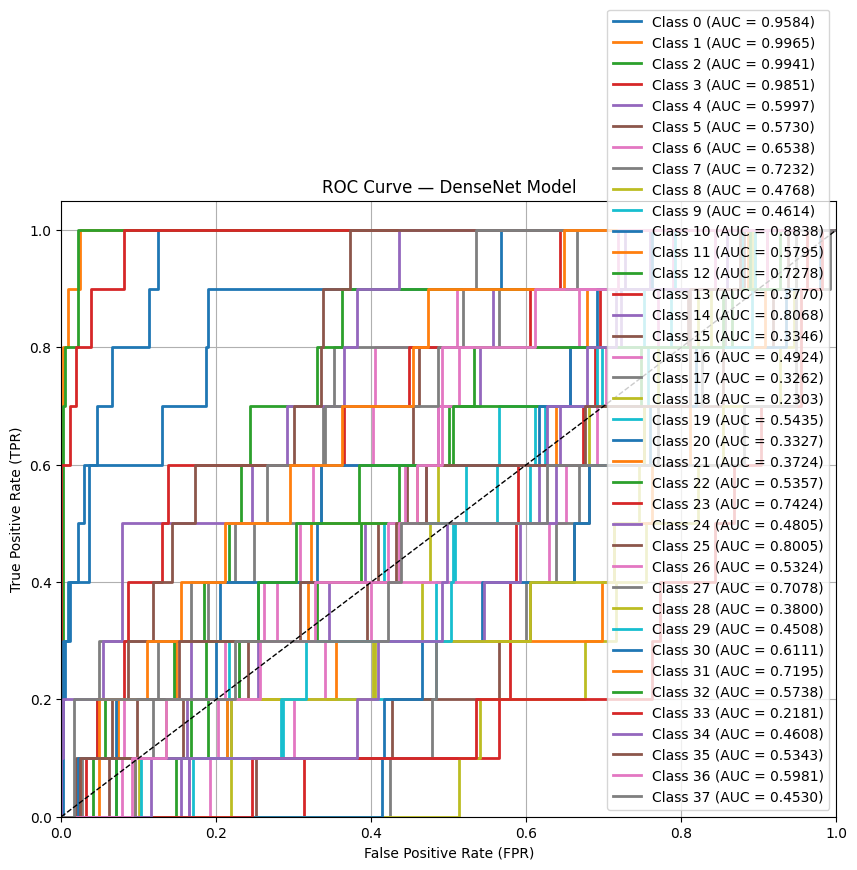

In [9]:
# ===========================================
# PART 5 — ROC CURVE & AUC PLOT (MULTI-CLASS)
# ===========================================

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

print("\n========== PART 5 — ROC & AUC CURVES ==========")

# -----------------------------
# Convert labels to one-hot
# -----------------------------
y_test_bin = label_binarize(all_labels, classes=np.arange(num_classes))

# -----------------------------
# Compute ROC for every class
# -----------------------------
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# -----------------------------
# PLOT — Multi-class ROC Curve
# -----------------------------
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(
        fpr[i], tpr[i],
        lw=2,
        label=f"Class {i} (AUC = {roc_auc[i]:.4f})"
    )

plt.plot([0, 1], [0, 1], 'k--', lw=1)  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve — DenseNet Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
